<a href="https://colab.research.google.com/github/Vnainhda/QR_CODE-_Classification/blob/main/QR_Code_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os


folder_path = "/content/drive/MyDrive/QR Classification"


print("Files in QR Classification folder:", os.listdir(folder_path))


Files in QR Classification folder: ['First Print-20250324T185657Z-001.zip', 'Second Print-20250324T185659Z-001.zip']


In [ ]:
import zipfile
import os

#  paths
folder_path = "/content/drive/MyDrive/QR Classification"
extract_path = "/content/dataset"


os.makedirs(extract_path, exist_ok=True)


for file in os.listdir(folder_path):
    if file.endswith(".zip"):
        zip_path = os.path.join(folder_path, file)
        print(f"Extracting: {zip_path} ...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)




Extracting: /content/drive/MyDrive/QR Classification/First Print-20250324T185657Z-001.zip ...
Extracting: /content/drive/MyDrive/QR Classification/Second Print-20250324T185659Z-001.zip ...


In [ ]:
import os
print("Extracted folders:", os.listdir("/content/dataset"))



Extracted folders: ['Second Print', 'First Print']


In [ ]:
#Rename
import os


os.rename("/content/dataset/First Print", "/content/dataset/first_print")
os.rename("/content/dataset/Second Print", "/content/dataset/second_print")

print("Folders renamed successfully!")


✅ Folders renamed successfully!


In [ ]:
dataset_path = "/content/dataset"
images, labels = load_images(dataset_path)



Detected categories: ['first_print', 'second_print']


***Traditional ML (Random Forest)***

In [ ]:
import os
import cv2
import numpy as np

def load_images(dataset_path):
    images = []
    labels = []


    categories = sorted(os.listdir(dataset_path))
    print("Detected categories:", categories)

    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)

        if not os.path.isdir(category_path):
            continue

        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Usagedataset_path = "/content/dataset"
images, labels = load_images(dataset_path)

print(" Loaded", len(images), "images successfully!")
print("Label distribution:", np.unique(labels, return_counts=True))


Detected categories: ['first_print', 'second_print']
 Loaded 200 images successfully!
Label distribution: (array([0, 1]), array([100, 100]))


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Preprocessing
images = np.array(images) / 255.0
labels = np.array(labels)


X = images.reshape(len(images), -1)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

print(" Data split complete! Train:", X_train.shape, "Test:", X_test.shape)

 Data split complete! Train: (160, 16384) Test: (40, 16384)


In [ ]:
#  Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.9

 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.83      1.00      0.91        20

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



***DL APPROACH***

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Convert images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Convert labels to categorical (if classification task)
num_classes = len(np.unique(labels))
labels = to_categorical(labels, num_classes=num_classes)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# 🔥 RESHAPE images to (128, 128, 1) for CNN (if grayscale)
X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

# 🔥 NORMALIZE pixel values to range [0,1] (important for CNNs)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Print shapes to confirm
print("✅ Data prepared. Train:", X_train.shape, "Test:", X_test.shape)


✅ Data prepared. Train: (160, 128, 128, 1) Test: (40, 128, 128, 1)


In [ ]:
#Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#   CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,258 (16.36 MB)

 Trainable params: 4,287,810 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=15
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 870ms/step - accuracy: 0.5294 - loss: 0.7679 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 990ms/step - accuracy: 0.5832 - loss: 0.6963 - val_accuracy: 0.5000 - val_loss: 0.7196
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7209 - loss: 0.5307 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 805ms/step - accuracy: 0.7705 - loss: 0.4810 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7912 - loss: 0.4265 - val_accuracy: 0.5000 - val_loss: 0.7102
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 823ms/step - accuracy: 0.8554 - loss: 0.3605 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 933ms/step - accuracy: 0.7832 - loss: 0.4033 - val_accuracy: 0.5000 - val_loss: 0.7235
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 999ms/step - accuracy: 0.8868 - loss: 0.2687 - val_accuracy: 0.5000 - val_

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(" Final Test Accuracy:", test_acc * 100, "%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4688 - loss: 2.8454
 Final Test Accuracy: 50.0 %


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))




2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


***Misclassification Analysis***

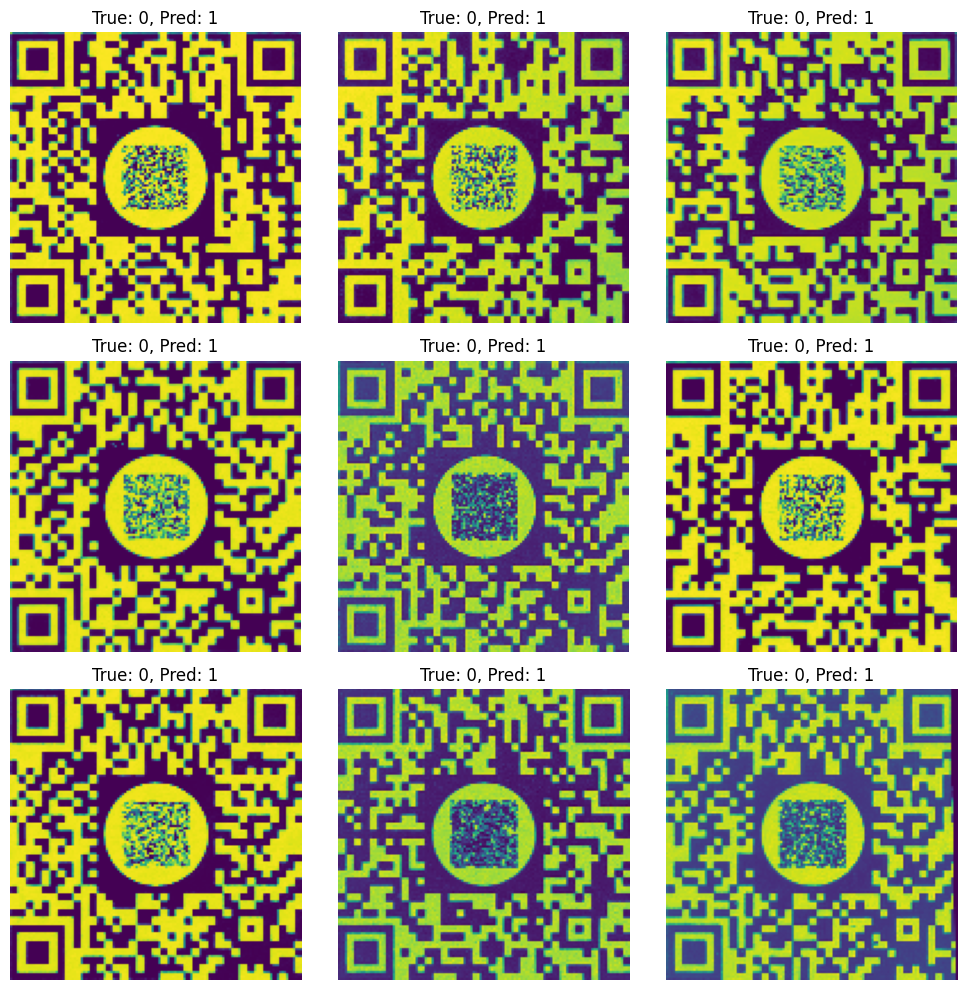

In [ ]:
# Find misclassified samples
misclassified_idxs = np.where(y_pred_classes != y_true_classes)[0]

# Show some misclassified images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    if i < len(misclassified_idxs):
        idx = misclassified_idxs[i]
        axes[i].imshow(X_test[idx])  # Show misclassified image
        axes[i].set_title(f"True: {y_true_classes[idx]}, Pred: {y_pred_classes[idx]}")
        axes[i].axis('off')

plt.tight_layout()
plt.show()
